# Pipeline: Predicción de precio por m² (arriendo y venta)

**Contenido:**  
- Conexión a base de datos
- Preprocesamiento y creación de `price_per_m2`  
- **Análisis de datos y eliminación de outliers** en precio y área
- Entrenamiento de **4 modelos**: CatBoost, LightGBM, RandomForest y Regresión Lineal
- Evaluación comparativa (RMSE, MAPE, R²)  
- Guardado de modelos y función de predicción

In [1]:
# Instalación de dependencias (ejecutar solo si es necesario)
!pip install catboost lightgbm scikit-learn pandas numpy matplotlib seaborn sqlalchemy psycopg2-binary -q


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\juanc\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
# =============================================================================
# CONFIGURACIÓN E IMPORTS
# =============================================================================
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Utilidades
from pathlib import Path
import json
import joblib
from datetime import datetime

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# ML imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor, Pool
import lightgbm as lgb

# Configuración de la base de datos
DB_URI = r"postgresql://admin:?x)YDctS\m>aUcSm@35.223.15.105:5432/toperty_appraisals"
TABLE_NAME = "property"

# Features y categorías - AHORA USANDO ÁREA NORMAL (no log)
# INCLUYE property_type: 1=Apartamento, 2=Casa, 3=Oficina, 4=Local, 5=Bodega, 6=Lote, 7=Estudio, 8=Penthouse, 9=Duplex, 0=Otro
FEATURES = [
    "area", "rooms", "baths", "garages", "stratum", "latitude", "longitude",
    "antiquity", "is_new", "area_per_room",
    "age_bucket", "has_garage", "city_id", "property_type"
]
CAT_FEATURES = ["is_new", "age_bucket", "city_id"]

# Métricas de evaluación
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    denom = np.where(y_true == 0, 1e-8, y_true)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100

print("✅ Imports y configuración completados")

✅ Imports y configuración completados


In [3]:
# =============================================================================
# CARGA DE DATOS
# =============================================================================
def load_data(db_uri=DB_URI, table_name=TABLE_NAME):
    """Carga datos desde la base de datos PostgreSQL"""
    if db_uri:
        try:
            from sqlalchemy import create_engine
            engine = create_engine(db_uri)
            df_loaded = pd.read_sql_table(table_name, engine)
            print(f"✅ Datos cargados desde DB: {df_loaded.shape}")
            return df_loaded
        except Exception as e:
            print(f"❌ Error al conectar a DB: {e}")
            return pd.DataFrame()
    return pd.DataFrame()

df_raw = load_data()
print(f"\nColumnas disponibles: {list(df_raw.columns)}")
print(f"\nPrimeras filas:")
df_raw.head()

✅ Datos cargados desde DB: (566213, 17)

Columnas disponibles: ['area', 'rooms', 'is_new', 'title', 'stratum', 'offer', 'garages', 'baths', 'price', 'latitude', 'longitude', 'location_main', 'fr_property_id', 'antiquity', 'last_update', 'city_id', 'creation_date']

Primeras filas:


,area,rooms,is_new,title,stratum,offer,garages,baths,price,latitude,longitude,location_main,fr_property_id,antiquity,last_update,city_id,creation_date
0,136.0,3,False,Apartamento en Venta,Estrato 5,sell,2,3,586000000.0,6.251594,-75.588799,Laureles,10689137,UNDEFINED,2024-03-14,26.0,2024-03-14
1,88.0,3,False,Apartamento en Arriendo,Estrato 6,rent,1,3,4700000.0,6.221083,-75.568914,Medellín,10687683,FROM_1_TO_8_YEARS,2024-03-17,1.0,2024-03-13
2,140.0,5,False,Apartamento en Venta,Estrato 5,sell,1,3,535000000.0,6.265312,-75.598466,None,10652211,UNDEFINED,2024-03-17,9.0,2024-03-06
3,95.0,3,False,Apartamento en Arriendo,Estrato 5,rent,1,3,3200000.0,6.223008,-75.569126,None,10628211,UNDEFINED,2024-03-07,15.0,2024-04-03
4,50.0,2,False,Apartamento en Arriendo,Estrato 2,rent,1,2,1400000.0,6.200188,-75.568822,None,10675783,FROM_1_TO_8_YEARS,2024-03-17,9.0,2024-03-09


ESTADÍSTICAS DESCRIPTIVAS ANTES DE ELIMINAR OUTLIERS

Shape inicial: (565535, 18)

📊 Estadísticas de PRECIO:
count    5.655350e+05
mean     1.006663e+09
std      4.639673e+10
min      1.000000e+00
25%      3.300000e+06
50%      2.190000e+08
75%      5.650000e+08
max      2.250000e+13
Name: price, dtype: float64

📊 Estadísticas de ÁREA:
count    5.655350e+05
mean     8.675909e+03
std      4.767471e+06
min      1.000000e-06
25%      6.000000e+01
50%      8.500000e+01
75%      1.500000e+02
max      3.580000e+09
Name: area, dtype: float64

📊 Estadísticas de PRECIO POR M²:
count    5.655350e+05
mean     3.369359e+09
std      2.526527e+12
min      2.314815e-03
25%      3.846154e+04
50%      2.941176e+06
75%      5.363636e+06
max      1.900000e+15
Name: price_per_m2, dtype: float64


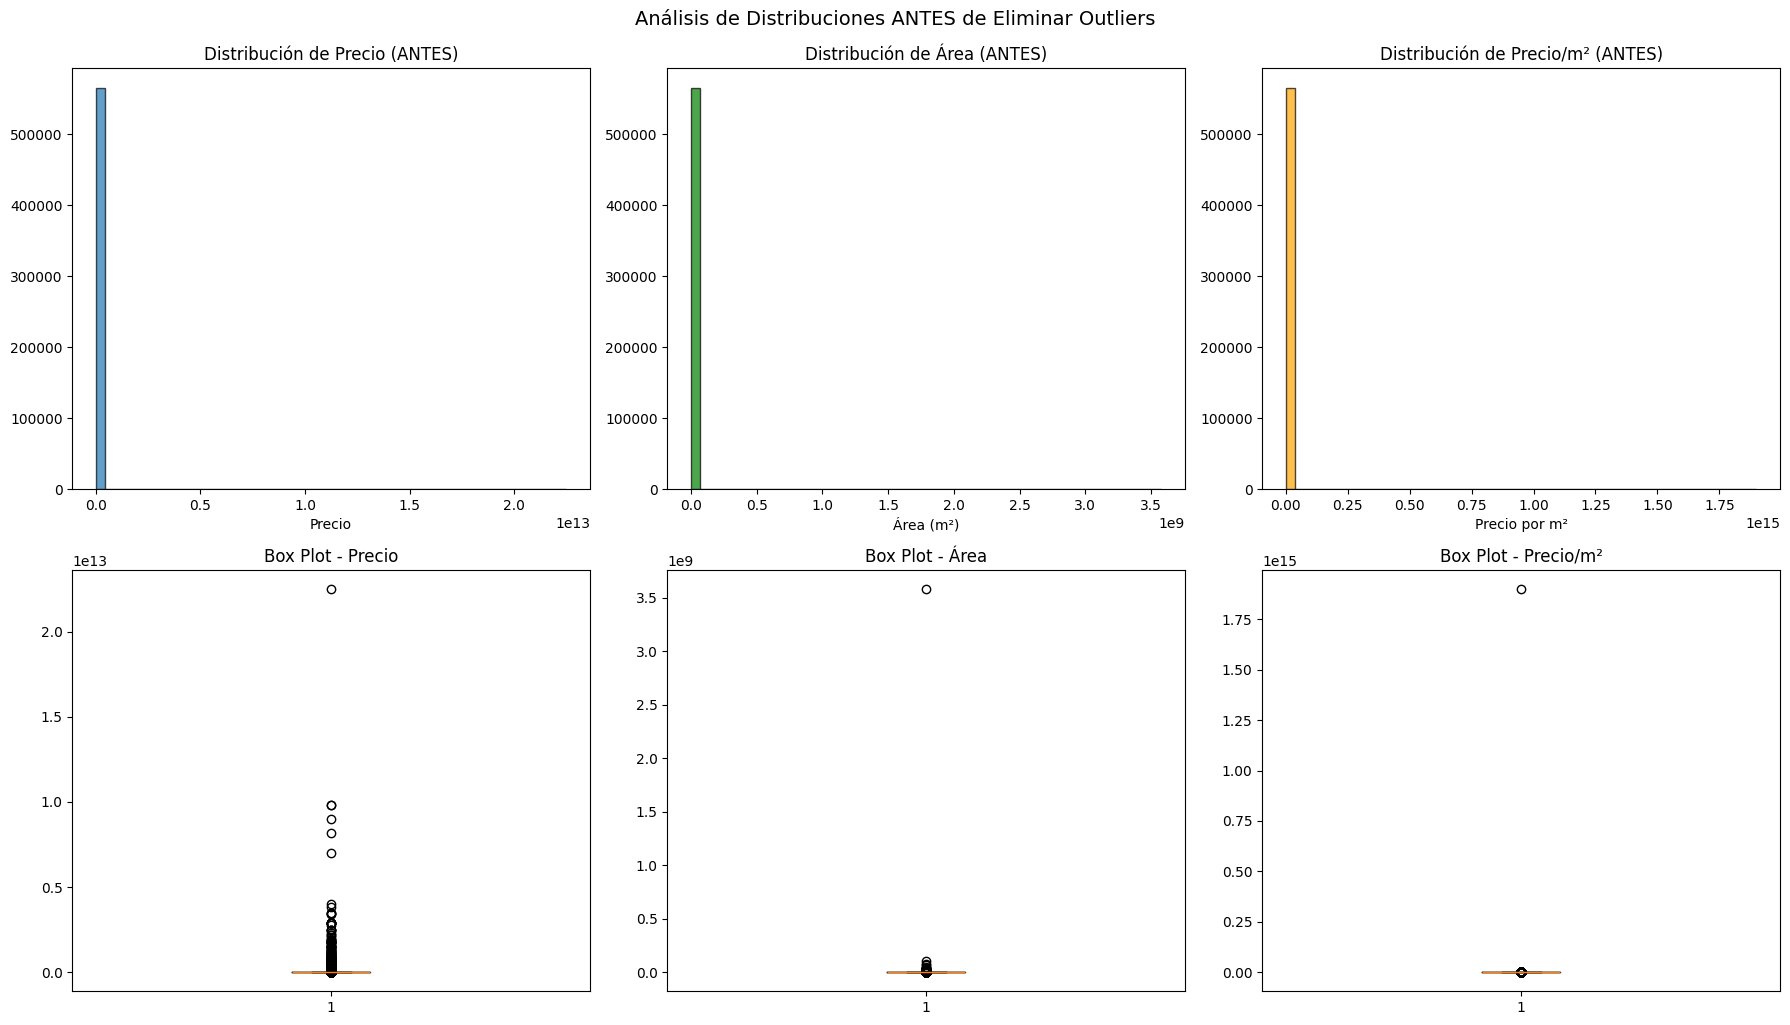

In [4]:
# =============================================================================
# ANÁLISIS EXPLORATORIO DE DATOS (EDA) - ANTES DE LIMPIAR
# =============================================================================
df = df_raw.copy()
df.columns = [c.strip() for c in df.columns]

# Filtrar datos básicos
df = df[(df['area'].notnull()) & (df['area'] > 0) & (df['price'].notnull())]
df['price_per_m2'] = df['price'] / df['area']

print("=" * 60)
print("ESTADÍSTICAS DESCRIPTIVAS ANTES DE ELIMINAR OUTLIERS")
print("=" * 60)
print(f"\nShape inicial: {df.shape}")
print(f"\n📊 Estadísticas de PRECIO:")
print(df['price'].describe())
print(f"\n📊 Estadísticas de ÁREA:")
print(df['area'].describe())
print(f"\n📊 Estadísticas de PRECIO POR M²:")
print(df['price_per_m2'].describe())

# Visualización de distribuciones ANTES de eliminar outliers
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Precio
axes[0, 0].hist(df['price'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribución de Precio (ANTES)')
axes[0, 0].set_xlabel('Precio')

# Área
axes[0, 1].hist(df['area'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].set_title('Distribución de Área (ANTES)')
axes[0, 1].set_xlabel('Área (m²)')

# Precio por m²
axes[0, 2].hist(df['price_per_m2'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[0, 2].set_title('Distribución de Precio/m² (ANTES)')
axes[0, 2].set_xlabel('Precio por m²')

# Box plots
axes[1, 0].boxplot(df['price'].dropna())
axes[1, 0].set_title('Box Plot - Precio')
axes[1, 1].boxplot(df['area'].dropna())
axes[1, 1].set_title('Box Plot - Área')
axes[1, 2].boxplot(df['price_per_m2'].dropna())
axes[1, 2].set_title('Box Plot - Precio/m²')

plt.tight_layout()
plt.suptitle('Análisis de Distribuciones ANTES de Eliminar Outliers', y=1.02, fontsize=14)
plt.show()

In [5]:
# =============================================================================
# ELIMINACIÓN DE OUTLIERS EN PRECIO Y ÁREA
# =============================================================================
def remove_outliers_iqr(df_in, column, verbose=True):
    """Elimina outliers usando el método IQR (Rango Intercuartil)"""
    initial_shape = df_in.shape[0]
    Q1 = df_in[column].quantile(0.25)
    Q3 = df_in[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df_filtered = df_in[(df_in[column] >= lower_bound) & (df_in[column] <= upper_bound)]
    
    if verbose:
        removed = initial_shape - df_filtered.shape[0]
        print(f"  📌 {column}: {initial_shape:,} → {df_filtered.shape[0]:,} (eliminadas: {removed:,})")
        print(f"      Límites: [{lower_bound:,.2f}, {upper_bound:,.2f}]")
    
    return df_filtered

print("=" * 60)
print("ELIMINACIÓN DE OUTLIERS")
print("=" * 60)
print(f"\nShape antes de eliminar outliers: {df.shape}")

# Eliminar outliers de PRECIO
print("\n🔧 Eliminando outliers de PRECIO:")
df = remove_outliers_iqr(df, 'price')

# Eliminar outliers de ÁREA
print("\n🔧 Eliminando outliers de ÁREA:")
df = remove_outliers_iqr(df, 'area')

# Recalcular price_per_m2 después de filtrar
df['price_per_m2'] = df['price'] / df['area']

# Eliminar outliers de PRECIO POR M²
print("\n🔧 Eliminando outliers de PRECIO POR M²:")
df = remove_outliers_iqr(df, 'price_per_m2')

print(f"\n✅ Shape después de eliminar outliers: {df.shape}")

ELIMINACIÓN DE OUTLIERS

Shape antes de eliminar outliers: (565535, 18)

🔧 Eliminando outliers de PRECIO:
  📌 price: 565,535 → 522,092 (eliminadas: 43,443)
      Límites: [-839,250,000.00, 1,407,550,000.00]

🔧 Eliminando outliers de ÁREA:
  📌 area: 522,092 → 472,556 (eliminadas: 49,536)
      Límites: [-44.90, 229.50]

🔧 Eliminando outliers de PRECIO POR M²:
  📌 price_per_m2: 472,556 → 469,105 (eliminadas: 3,451)
      Límites: [-7,720,068.27, 12,965,954.01]

✅ Shape después de eliminar outliers: (469105, 18)


ESTADÍSTICAS DESPUÉS DE ELIMINAR OUTLIERS

📊 Estadísticas de PRECIO (después):
count    4.691050e+05
mean     2.639736e+08
std      3.173279e+08
min      1.000000e+00
25%      2.600000e+06
50%      1.780000e+08
75%      4.300000e+08
max      1.406000e+09
Name: price, dtype: float64

📊 Estadísticas de ÁREA (después):
count    469105.000000
mean         86.663799
std          43.982430
min           0.100000
25%          56.000000
50%          75.000000
75%         109.000000
max         229.500000
Name: area, dtype: float64

📊 Estadísticas de PRECIO POR M² (después):
count    4.691050e+05
mean     2.906968e+06
std      2.995852e+06
min      5.847953e-03
25%      3.700000e+04
50%      2.857143e+06
75%      5.156250e+06
max      1.296296e+07
Name: price_per_m2, dtype: float64


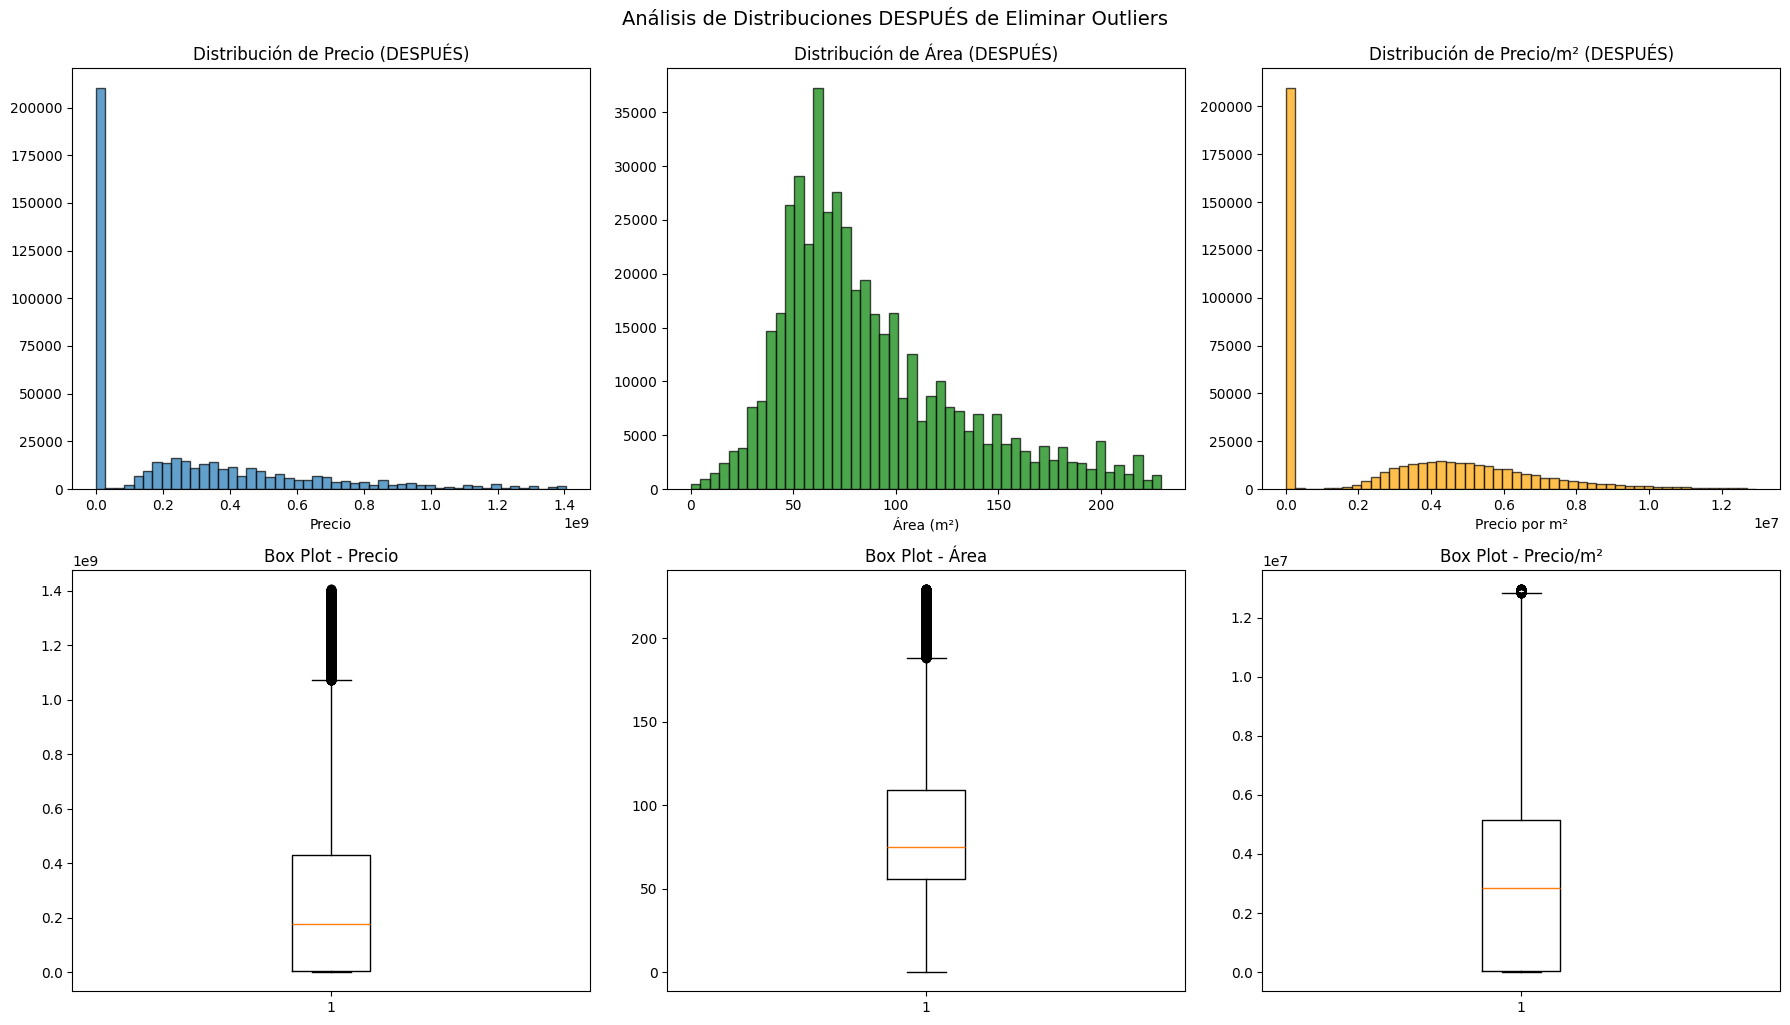

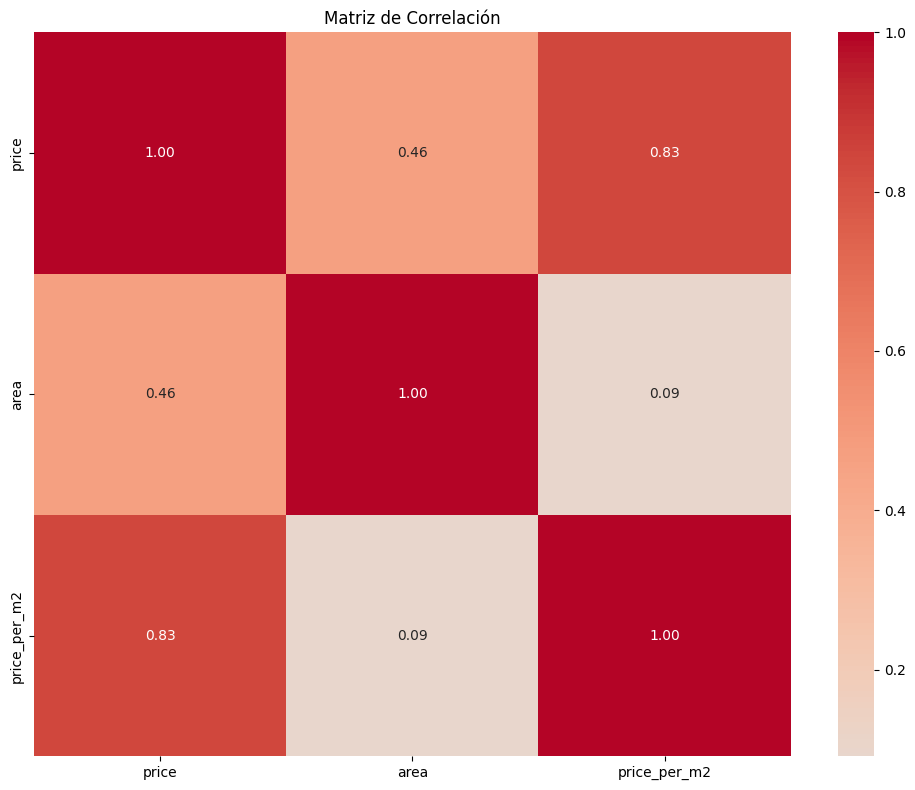

In [6]:
# =============================================================================
# VISUALIZACIÓN DESPUÉS DE ELIMINAR OUTLIERS
# =============================================================================
print("=" * 60)
print("ESTADÍSTICAS DESPUÉS DE ELIMINAR OUTLIERS")
print("=" * 60)
print(f"\n📊 Estadísticas de PRECIO (después):")
print(df['price'].describe())
print(f"\n📊 Estadísticas de ÁREA (después):")
print(df['area'].describe())
print(f"\n📊 Estadísticas de PRECIO POR M² (después):")
print(df['price_per_m2'].describe())

# Visualización de distribuciones DESPUÉS de eliminar outliers
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Precio
axes[0, 0].hist(df['price'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribución de Precio (DESPUÉS)')
axes[0, 0].set_xlabel('Precio')

# Área
axes[0, 1].hist(df['area'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].set_title('Distribución de Área (DESPUÉS)')
axes[0, 1].set_xlabel('Área (m²)')

# Precio por m²
axes[0, 2].hist(df['price_per_m2'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[0, 2].set_title('Distribución de Precio/m² (DESPUÉS)')
axes[0, 2].set_xlabel('Precio por m²')

# Box plots
axes[1, 0].boxplot(df['price'].dropna())
axes[1, 0].set_title('Box Plot - Precio')
axes[1, 1].boxplot(df['area'].dropna())
axes[1, 1].set_title('Box Plot - Área')
axes[1, 2].boxplot(df['price_per_m2'].dropna())
axes[1, 2].set_title('Box Plot - Precio/m²')

plt.tight_layout()
plt.suptitle('Análisis de Distribuciones DESPUÉS de Eliminar Outliers', y=1.02, fontsize=14)
plt.show()

# Matriz de correlación - SOLO columnas numéricas válidas
numeric_cols = ['price', 'area', 'price_per_m2', 'rooms', 'baths', 'garages']
# Filtrar solo las columnas que existen y son numéricas
valid_numeric = []
for c in numeric_cols:
    if c in df.columns:
        # Verificar que la columna sea realmente numérica
        if pd.api.types.is_numeric_dtype(df[c]):
            valid_numeric.append(c)

if len(valid_numeric) > 1:
    corr_matrix = df[valid_numeric].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('Matriz de Correlación')
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No hay suficientes columnas numéricas para la matriz de correlación")

## 📊 Análisis Detallado de Variables - Recomendaciones de Filtrado

In [7]:
# =============================================================================
# ANÁLISIS DETALLADO DE CADA VARIABLE - RECOMENDACIONES DE FILTRADO
# =============================================================================
print("=" * 80)
print("🔍 ANÁLISIS DETALLADO DE VARIABLES PARA MEJORAR PREDICCIÓN")
print("=" * 80)

def analyze_variable(df_in, col, offer_type=None):
    """Analiza una variable y sugiere filtros"""
    if offer_type:
        data = df_in[df_in['offer'] == offer_type][col].dropna()
        title = f"{col.upper()} ({offer_type.upper()})"
    else:
        data = df_in[col].dropna()
        title = f"{col.upper()} (TODOS)"
    
    # Convertir a numérico si es necesario
    data = pd.to_numeric(data, errors='coerce').dropna()
    
    if len(data) == 0:
        print(f"\n⚠️ {title}: Sin datos numéricos")
        return None
    
    stats = {
        'count': len(data),
        'mean': data.mean(),
        'std': data.std(),
        'min': data.min(),
        'p1': data.quantile(0.01),
        'p5': data.quantile(0.05),
        'p25': data.quantile(0.25),
        'median': data.quantile(0.50),
        'p75': data.quantile(0.75),
        'p95': data.quantile(0.95),
        'p99': data.quantile(0.99),
        'max': data.max()
    }
    
    # Coeficiente de variación
    cv = (stats['std'] / stats['mean']) * 100 if stats['mean'] != 0 else 0
    
    print(f"\n{'='*60}")
    print(f"📌 {title}")
    print(f"{'='*60}")
    print(f"  N = {stats['count']:,}")
    print(f"  Media = {stats['mean']:,.2f} | Mediana = {stats['median']:,.2f}")
    print(f"  Std = {stats['std']:,.2f} | CV = {cv:.1f}%")
    print(f"  Rango: [{stats['min']:,.2f} → {stats['max']:,.2f}]")
    print(f"  Percentiles: P1={stats['p1']:,.2f} | P5={stats['p5']:,.2f} | P95={stats['p95']:,.2f} | P99={stats['p99']:,.2f}")
    
    return stats

# ============================================================================
# 1. ANÁLISIS DE ÁREA
# ============================================================================
print("\n" + "🏠" * 30)
print("1. ANÁLISIS DE ÁREA (m²)")
print("🏠" * 30)

for offer in ['rent', 'sell']:
    stats = analyze_variable(df, 'area', offer)

# Valores atípicos de área
print("\n📋 DISTRIBUCIÓN DE ÁREA POR RANGOS:")
bins_area = [0, 30, 50, 80, 120, 200, 500, 1000, float('inf')]
labels_area = ['<30', '30-50', '50-80', '80-120', '120-200', '200-500', '500-1000', '>1000']
df['area_range'] = pd.cut(df['area'], bins=bins_area, labels=labels_area)
print(df.groupby(['offer', 'area_range']).size().unstack(fill_value=0))

# ============================================================================
# 2. ANÁLISIS DE PRECIO
# ============================================================================
print("\n" + "💰" * 30)
print("2. ANÁLISIS DE PRECIO")
print("💰" * 30)

for offer in ['rent', 'sell']:
    stats = analyze_variable(df, 'price', offer)

# ============================================================================
# 3. ANÁLISIS DE PRECIO POR M²
# ============================================================================
print("\n" + "📊" * 30)
print("3. ANÁLISIS DE PRECIO POR M²")
print("📊" * 30)

for offer in ['rent', 'sell']:
    stats = analyze_variable(df, 'price_per_m2', offer)

# ============================================================================
# 4. ANÁLISIS DE HABITACIONES
# ============================================================================
print("\n" + "🛏️" * 30)
print("4. ANÁLISIS DE HABITACIONES")
print("🛏️" * 30)

print("\n📋 DISTRIBUCIÓN DE HABITACIONES:")
print(df.groupby(['offer', 'rooms']).size().unstack(fill_value=0).T)

# Convertir a numérico para comparaciones
rooms_numeric = pd.to_numeric(df['rooms'], errors='coerce')
rooms_issues = df[(rooms_numeric < 0) | (rooms_numeric > 10) | rooms_numeric.isna()]
print(f"\n⚠️ Registros con habitaciones inválidas (< 0, > 10 o no numérico): {len(rooms_issues):,}")

# ============================================================================
# 5. ANÁLISIS DE BAÑOS
# ============================================================================
print("\n" + "🚿" * 30)
print("5. ANÁLISIS DE BAÑOS")
print("🚿" * 30)

print("\n📋 DISTRIBUCIÓN DE BAÑOS:")
print(df.groupby(['offer', 'baths']).size().unstack(fill_value=0).T)

baths_numeric = pd.to_numeric(df['baths'], errors='coerce')
baths_issues = df[(baths_numeric < 0) | (baths_numeric > 10) | baths_numeric.isna()]
print(f"\n⚠️ Registros con baños inválidos (< 0, > 10 o no numérico): {len(baths_issues):,}")

# ============================================================================
# 6. ANÁLISIS DE ESTRATO
# ============================================================================
print("\n" + "🏢" * 30)
print("6. ANÁLISIS DE ESTRATO")
print("🏢" * 30)

print("\n📋 DISTRIBUCIÓN DE ESTRATO:")
print(df.groupby(['offer', 'stratum']).size().unstack(fill_value=0).T)

stratum_numeric = pd.to_numeric(df['stratum'], errors='coerce')
stratum_issues = df[(stratum_numeric < 1) | (stratum_numeric > 6) | stratum_numeric.isna()]
print(f"\n⚠️ Registros con estrato inválido (< 1, > 6 o no numérico): {len(stratum_issues):,}")

# ============================================================================
# 7. ANÁLISIS DE ANTIGÜEDAD
# ============================================================================
print("\n" + "📅" * 30)
print("7. ANÁLISIS DE ANTIGÜEDAD")
print("📅" * 30)

for offer in ['rent', 'sell']:
    stats = analyze_variable(df, 'antiquity', offer)

antiquity_numeric = pd.to_numeric(df['antiquity'], errors='coerce')
antiquity_issues = df[(antiquity_numeric < -1) | (antiquity_numeric > 100) | antiquity_numeric.isna()]
print(f"\n⚠️ Registros con antigüedad fuera de rango (-1 a 100) o inválida: {len(antiquity_issues):,}")

# ============================================================================
# 8. ANÁLISIS DE COORDENADAS
# ============================================================================
print("\n" + "🌍" * 30)
print("8. ANÁLISIS DE COORDENADAS")
print("🌍" * 30)

# Convertir a numérico
lat_numeric = pd.to_numeric(df['latitude'], errors='coerce')
lon_numeric = pd.to_numeric(df['longitude'], errors='coerce')

# Colombia aproximadamente: lat 0-13, lon -82 a -66
lat_issues = df[(lat_numeric < 0) | (lat_numeric > 13) | (lat_numeric == -1) | lat_numeric.isna()]
lon_issues = df[(lon_numeric > -60) | (lon_numeric < -82) | (lon_numeric == -1) | lon_numeric.isna()]

print(f"\n📍 Latitud: min={lat_numeric.min():.4f}, max={lat_numeric.max():.4f}")
print(f"   ⚠️ Registros con latitud fuera de Colombia (0-13) o inválida: {len(lat_issues):,}")
print(f"\n📍 Longitud: min={lon_numeric.min():.4f}, max={lon_numeric.max():.4f}")
print(f"   ⚠️ Registros con longitud fuera de Colombia (-82 a -60) o inválida: {len(lon_issues):,}")

# ============================================================================
# 9. ANÁLISIS DE UBICACIONES - OMITIDO
# ============================================================================
print("\n" + "📍" * 30)
print("9. ANÁLISIS DE UBICACIONES - CAMPO ELIMINADO")
print("📍" * 30)
print("\n⚠️ El campo location_main ha sido eliminado del modelo")

# ============================================================================
# 10. ANÁLISIS DE CITY_ID
# ============================================================================
print("\n" + "🏙️" * 30)
print("10. ANÁLISIS DE CIUDADES (city_id)")
print("🏙️" * 30)

if 'city_id' in df.columns:
    city_counts = df.groupby(['offer', 'city_id']).size().unstack(fill_value=0)
    print(city_counts.T)

# ============================================================================
# 11. RESUMEN DE PROBLEMAS ENCONTRADOS
# ============================================================================
print("\n" + "=" * 80)
print("📋 RESUMEN DE VALORES PROBLEMÁTICOS ENCONTRADOS")
print("=" * 80)

total_records = len(df)
print(f"\nTotal de registros: {total_records:,}")
print(f"\nProblemas por variable:")
print(f"  • Habitaciones inválidas: {len(rooms_issues):,} ({100*len(rooms_issues)/total_records:.1f}%)")
print(f"  • Baños inválidos: {len(baths_issues):,} ({100*len(baths_issues)/total_records:.1f}%)")
print(f"  • Estrato inválido: {len(stratum_issues):,} ({100*len(stratum_issues)/total_records:.1f}%)")
print(f"  • Antigüedad inválida: {len(antiquity_issues):,} ({100*len(antiquity_issues)/total_records:.1f}%)")
print(f"  • Latitud inválida: {len(lat_issues):,} ({100*len(lat_issues)/total_records:.1f}%)")
print(f"  • Longitud inválida: {len(lon_issues):,} ({100*len(lon_issues)/total_records:.1f}%)")


🔍 ANÁLISIS DETALLADO DE VARIABLES PARA MEJORAR PREDICCIÓN

🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠
1. ANÁLISIS DE ÁREA (m²)
🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠🏠

📌 AREA (RENT)
  N = 210,356
  Media = 80.38 | Mediana = 70.00
  Std = 43.08 | CV = 53.6%
  Rango: [0.10 → 229.50]
  Percentiles: P1=12.00 | P5=28.00 | P95=175.00 | P99=215.00

📌 AREA (SELL)
  N = 258,749
  Media = 91.77 | Mediana = 80.00
  Std = 44.05 | CV = 48.0%
  Rango: [1.00 → 229.45]
  Percentiles: P1=27.00 | P5=41.00 | P95=185.00 | P99=218.00

📋 DISTRIBUCIÓN DE ÁREA POR RANGOS:
area_range    <30  30-50  50-80  80-120  120-200  200-500  500-1000  >1000
offer                                                                     
rent        13728  36737  82018   46118    27889     3866         0      0
sell         4018  31216  97450   68631    50694     6740         0      0

💰💰💰💰💰💰💰💰💰💰💰💰💰💰💰💰💰💰💰💰💰💰💰💰💰💰💰💰💰💰
2. ANÁLISIS DE PRECIO
💰💰💰💰💰💰💰💰💰💰💰💰💰💰💰💰💰💰💰💰💰💰💰💰💰💰💰💰💰💰

📌 PRICE (RENT)
  N = 210,356
  Media = 3,793,666.99 | Mediana = 2,371,500.00
  S

In [8]:
# =============================================================================
# 📋 RESUMEN DE RECOMENDACIONES DE FILTRADO
# =============================================================================
print("=" * 80)
print("📋 RESUMEN DE RECOMENDACIONES DE FILTRADO PARA TODOS LOS MODELOS")
print("=" * 80)

# Guardar shape original
shape_before = df.shape[0]

print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║                    FILTROS RECOMENDADOS PARA ML                              ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  1. ÁREA                                                                     ║
║     - Mínimo: 15 m² (excluir micro-espacios/errores)                         ║
║     - Máximo: 500 m² para arriendo, 1000 m² para venta                       ║
║     - Razón: Valores extremos distorsionan predicciones                      ║
║                                                                              ║
║  2. PRECIO POR M²                                                            ║
║     - Usar percentiles P5-P95 por tipo de oferta                             ║
║     - Razón: Eliminar precios irreales (errores de captura)                  ║
║                                                                              ║
║  3. HABITACIONES                                                             ║
║     - Rango válido: 0-8 (estudios hasta penthouses grandes)                  ║
║     - Excluir: -1 (desconocido) y > 8 (probables errores)                    ║
║                                                                              ║
║  4. BAÑOS                                                                    ║
║     - Rango válido: 1-6                                                      ║
║     - Excluir: 0 (improbable) y > 6 (errores)                                ║
║                                                                              ║
║  5. ESTRATO                                                                  ║
║     - Rango válido: 1-6 (estratificación colombiana)                         ║
║     - Excluir: -1 (desconocido), 0, > 6                                      ║
║                                                                              ║
║  6. COORDENADAS                                                              ║
║     - Latitud Colombia: 0 a 13                                               ║
║     - Longitud Colombia: -82 a -66                                           ║
║     - Excluir: coordenadas fuera de Colombia o -1 (desconocido)              ║
║                                                                              ║
║  7. ANTIGÜEDAD                                                               ║
║     - Rango válido: 0-80 años                                                ║
║     - Excluir: > 80 años (improbable/error)                                  ║
║                                                                              ║
║  8. UBICACIONES                                                              ║
║     - Campo location_main eliminado del modelo                               ║
║     - Razón: Reduce complejidad y mejora generalización                      ║
║                                                                              ║
║  9. RELACIÓN ROOMS/AREA                                                      ║
║     - area_per_room debe estar entre 8-100 m²                                ║
║     - < 8 m²: micro-habitaciones irreales                                    ║
║     - > 100 m²: probablemente datos incorrectos                              ║
║                                                                              ║
║  10. GARAJES                                                                 ║
║      - Rango válido: 0-5                                                     ║
║      - > 5: Probables errores                                                ║
║                                                                              ║
╚══════════════════════════════════════════════════════════════════════════════╝
""")

# Calcular impacto de cada filtro
print("\n" + "="*60)
print("📊 IMPACTO DE CADA FILTRO (simulación)")
print("="*60)

df_test = df.copy()

# Convertir columnas a numérico para comparaciones
df_test['rooms_num'] = pd.to_numeric(df_test['rooms'], errors='coerce').fillna(-999)
df_test['baths_num'] = pd.to_numeric(df_test['baths'], errors='coerce').fillna(-999)
df_test['stratum_num'] = pd.to_numeric(df_test['stratum'], errors='coerce').fillna(-999)
df_test['garages_num'] = pd.to_numeric(df_test['garages'], errors='coerce').fillna(-999)
df_test['latitude_num'] = pd.to_numeric(df_test['latitude'], errors='coerce').fillna(-999)
df_test['longitude_num'] = pd.to_numeric(df_test['longitude'], errors='coerce').fillna(-999)
df_test['antiquity_num'] = pd.to_numeric(df_test['antiquity'], errors='coerce').fillna(-999)

filters_impact = []

# Filtro 1: Área
mask_area = (df_test['area'] >= 15) & (
    ((df_test['offer'] == 'rent') & (df_test['area'] <= 500)) |
    ((df_test['offer'] == 'sell') & (df_test['area'] <= 1000))
)
removed = len(df_test) - mask_area.sum()
filters_impact.append({'Filtro': 'Área (15-500/1000 m²)', 'Eliminados': removed, 'Restantes': mask_area.sum()})
print(f"  1. Área: eliminaría {removed:,} registros")

# Filtro 2: Habitaciones
mask_rooms = (df_test['rooms_num'] >= 0) & (df_test['rooms_num'] <= 8)
removed = len(df_test) - mask_rooms.sum()
filters_impact.append({'Filtro': 'Habitaciones (0-8)', 'Eliminados': removed, 'Restantes': mask_rooms.sum()})
print(f"  2. Habitaciones: eliminaría {removed:,} registros")

# Filtro 3: Baños
mask_baths = (df_test['baths_num'] >= 1) & (df_test['baths_num'] <= 6)
removed = len(df_test) - mask_baths.sum()
filters_impact.append({'Filtro': 'Baños (1-6)', 'Eliminados': removed, 'Restantes': mask_baths.sum()})
print(f"  3. Baños: eliminaría {removed:,} registros")

# Filtro 4: Estrato
mask_stratum = (df_test['stratum_num'] >= 1) & (df_test['stratum_num'] <= 6)
removed = len(df_test) - mask_stratum.sum()
filters_impact.append({'Filtro': 'Estrato (1-6)', 'Eliminados': removed, 'Restantes': mask_stratum.sum()})
print(f"  4. Estrato: eliminaría {removed:,} registros")

# Filtro 5: Coordenadas
mask_coords = (df_test['latitude_num'] >= 0) & (df_test['latitude_num'] <= 13) & \
              (df_test['longitude_num'] >= -82) & (df_test['longitude_num'] <= -66)
removed = len(df_test) - mask_coords.sum()
filters_impact.append({'Filtro': 'Coordenadas Colombia', 'Eliminados': removed, 'Restantes': mask_coords.sum()})
print(f"  5. Coordenadas: eliminaría {removed:,} registros")

# Filtro 6: Garajes
mask_garages = (df_test['garages_num'] >= 0) & (df_test['garages_num'] <= 5)
removed = len(df_test) - mask_garages.sum()
filters_impact.append({'Filtro': 'Garajes (0-5)', 'Eliminados': removed, 'Restantes': mask_garages.sum()})
print(f"  6. Garajes: eliminaría {removed:,} registros")

# Filtro 7: Antigüedad
mask_antiquity = (df_test['antiquity_num'] >= -1) & (df_test['antiquity_num'] <= 80)
removed = len(df_test) - mask_antiquity.sum()
filters_impact.append({'Filtro': 'Antigüedad (-1 a 80)', 'Eliminados': removed, 'Restantes': mask_antiquity.sum()})
print(f"  7. Antigüedad: eliminaría {removed:,} registros")

# Filtro 8: Area per room (ya debería ser numérico)
if 'area_per_room' not in df_test.columns:
    df_test['area_per_room'] = np.where(
        df_test['rooms_num'] > 0,
        df_test['area'] / df_test['rooms_num'],
        df_test['area']
    )
mask_apr = (df_test['area_per_room'] >= 8) & (df_test['area_per_room'] <= 100)
removed = len(df_test) - mask_apr.sum()
filters_impact.append({'Filtro': 'Área por habitación (8-100)', 'Eliminados': removed, 'Restantes': mask_apr.sum()})
print(f"  8. Área/habitación: eliminaría {removed:,} registros")

# TODOS LOS FILTROS COMBINADOS
mask_all = mask_area & mask_rooms & mask_baths & mask_stratum & mask_coords & mask_garages & mask_antiquity & mask_apr
total_removed = len(df_test) - mask_all.sum()
print(f"\n  📌 TODOS LOS FILTROS COMBINADOS: eliminaría {total_removed:,} de {len(df_test):,} ({100*total_removed/len(df_test):.1f}%)")
print(f"     Registros restantes: {mask_all.sum():,}")

# Mostrar tabla resumen
print("\n" + "="*60)
print("📊 TABLA RESUMEN DE IMPACTO")
print("="*60)
impact_df = pd.DataFrame(filters_impact)
impact_df['% Eliminado'] = (impact_df['Eliminados'] / len(df_test) * 100).round(1)
print(impact_df.to_string(index=False))

📋 RESUMEN DE RECOMENDACIONES DE FILTRADO PARA TODOS LOS MODELOS

╔══════════════════════════════════════════════════════════════════════════════╗
║                    FILTROS RECOMENDADOS PARA ML                              ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  1. ÁREA                                                                     ║
║     - Mínimo: 15 m² (excluir micro-espacios/errores)                         ║
║     - Máximo: 500 m² para arriendo, 1000 m² para venta                       ║
║     - Razón: Valores extremos distorsionan predicciones                      ║
║                                                                              ║
║  2. PRECIO POR M²                                                            ║
║     - Usar percentiles P5-P95 por tipo de oferta                             ║
║     - Razón: Eliminar precios irreales (er

In [9]:
# =============================================================================
# 🔧 APLICAR FILTROS RECOMENDADOS
# =============================================================================
print("=" * 80)
print("🔧 APLICANDO FILTROS RECOMENDADOS")
print("=" * 80)

shape_before_filters = df.shape[0]

# Función para extraer número del estrato (ej: "Estrato 5" -> 5)
def extract_stratum(val):
    if pd.isna(val):
        return np.nan
    if isinstance(val, (int, float)):
        return val
    val_str = str(val)
    # Buscar números en el string
    import re
    match = re.search(r'\d+', val_str)
    if match:
        return int(match.group())
    return np.nan

# Función para convertir antigüedad textual a numérica
# Valores de la BD: LESS_THAN_1_YEAR, FROM_1_TO_8_YEARS, FROM_9_TO_15_YEARS, FROM_16_TO_30_YEARS, MORE_THAN_30_YEARS, UNDEFINED
def convert_antiquity(val):
    """
    Convierte antigüedad textual a categoría numérica.
    Retorna:
        1 = Menos de 1 año (nuevo)
        2 = 1 a 8 años
        3 = 9 a 15 años
        4 = 16 a 30 años
        5 = Más de 30 años
        0 = Sin especificar/Desconocido
    """
    if pd.isna(val) or val is None or val == '':
        return 0  # Sin especificar
    
    if isinstance(val, (int, float)):
        return int(val) if val in [0, 1, 2, 3, 4, 5] else 0
    
    val_str = str(val).upper().strip()
    
    # Categoría 1: Menos de 1 año
    if val_str in ['LESS_THAN_1_YEAR', 'MENOS DE 1 AÑO', '1', 'NEW', 'NUEVO']:
        return 1
    
    # Categoría 2: 1 a 8 años
    elif val_str in ['FROM_1_TO_8_YEARS', '1 A 8 AÑOS', '2']:
        return 2
    
    # Categoría 3: 9 a 15 años
    elif val_str in ['FROM_9_TO_15_YEARS', '9 A 15 AÑOS', '3']:
        return 3
    
    # Categoría 4: 16 a 30 años
    elif val_str in ['FROM_16_TO_30_YEARS', '16 A 30 AÑOS', '4']:
        return 4
    
    # Categoría 5: Más de 30 años
    elif val_str in ['MORE_THAN_30_YEARS', 'MÁS DE 30 AÑOS', 'MAS DE 30 AÑOS', '5']:
        return 5
    
    # Sin especificar
    elif val_str in ['UNDEFINED', 'SIN ESPECIFICAR', '0', '']:
        return 0
    
    else:
        return 0  # Default: desconocido

# Diccionario para mostrar nombres de antigüedad
ANTIQUITY_NAMES = {
    0: 'Sin especificar',
    1: 'Menos de 1 año',
    2: '1 a 8 años',
    3: '9 a 15 años',
    4: '16 a 30 años',
    5: 'Más de 30 años'
}

# Primero veamos la distribución de estrato antes de filtrar
print("\n📊 Valores únicos de ESTRATO antes de filtrar:")
print(df['stratum'].value_counts().head(10))

# Crear función de filtrado completa
def apply_recommended_filters(df_in, verbose=True):
    """Aplica todos los filtros recomendados para ML"""
    df_out = df_in.copy()
    initial = len(df_out)
    
    if verbose:
        print(f"\n📊 Registros iniciales: {initial:,}")
    
    # Convertir columnas a numérico con funciones especializadas
    df_out['rooms'] = pd.to_numeric(df_out['rooms'], errors='coerce')
    df_out['baths'] = pd.to_numeric(df_out['baths'], errors='coerce')
    df_out['stratum'] = df_out['stratum'].apply(extract_stratum)  # Extraer número de "Estrato X"
    df_out['garages'] = pd.to_numeric(df_out['garages'], errors='coerce')
    df_out['latitude'] = pd.to_numeric(df_out['latitude'], errors='coerce')
    df_out['longitude'] = pd.to_numeric(df_out['longitude'], errors='coerce')
    df_out['antiquity'] = df_out['antiquity'].apply(convert_antiquity)  # Convertir texto a número
    
    if verbose:
        print(f"  📌 Estrato después de conversión: {df_out['stratum'].value_counts().to_dict()}")
    
    # 1. Filtro de ÁREA
    mask = (df_out['area'] >= 15) & (
        ((df_out['offer'] == 'rent') & (df_out['area'] <= 500)) |
        ((df_out['offer'] == 'sell') & (df_out['area'] <= 1000))
    )
    removed = len(df_out) - mask.sum()
    df_out = df_out[mask]
    if verbose:
        print(f"  1. Área (15-500/1000 m²): -{removed:,} → {len(df_out):,}")
    
    # 2. Filtro de HABITACIONES (permitir NaN, solo filtrar extremos)
    mask = (df_out['rooms'].isna()) | ((df_out['rooms'] >= 0) & (df_out['rooms'] <= 10))
    removed = len(df_out) - mask.sum()
    df_out = df_out[mask]
    if verbose:
        print(f"  2. Habitaciones (0-10 o NaN): -{removed:,} → {len(df_out):,}")
    
    # Imputar habitaciones NaN con mediana
    rooms_median = df_out['rooms'].median()
    df_out['rooms'] = df_out['rooms'].fillna(rooms_median if pd.notna(rooms_median) else 3)
    
    # 3. Filtro de BAÑOS - más permisivo (permitir NaN)
    mask = (df_out['baths'].isna()) | ((df_out['baths'] >= 0) & (df_out['baths'] <= 8))
    removed = len(df_out) - mask.sum()
    df_out = df_out[mask]
    if verbose:
        print(f"  3. Baños (0-8 o NaN): -{removed:,} → {len(df_out):,}")
    
    # Imputar baños NaN con mediana
    baths_median = df_out['baths'].median()
    df_out['baths'] = df_out['baths'].fillna(baths_median if pd.notna(baths_median) else 2)
    
    # 4. Filtro de ESTRATO (0-6, incluir 0 para desconocidos, permitir NaN)
    # Primero asignar 0 a NaN de estrato (desconocido)
    df_out['stratum'] = df_out['stratum'].fillna(0)
    mask = (df_out['stratum'] >= 0) & (df_out['stratum'] <= 6)
    removed = len(df_out) - mask.sum()
    df_out = df_out[mask]
    if verbose:
        print(f"  4. Estrato (0-6, 0=desconocido): -{removed:,} → {len(df_out):,}")
    
    # 5. Filtro de COORDENADAS (Colombia) - permitir NaN
    mask = (df_out['latitude'].isna()) | (
        (df_out['latitude'] >= -5) & (df_out['latitude'] <= 15) & 
        (df_out['longitude'] >= -82) & (df_out['longitude'] <= -66)
    )
    removed = len(df_out) - mask.sum()
    df_out = df_out[mask]
    if verbose:
        print(f"  5. Coordenadas Colombia (o NaN): -{removed:,} → {len(df_out):,}")
    
    # Imputar coordenadas NaN con mediana (Bogotá como default)
    df_out['latitude'] = df_out['latitude'].fillna(4.65)  # Bogotá
    df_out['longitude'] = df_out['longitude'].fillna(-74.1)  # Bogotá
    
    # 6. Filtro de GARAJES (permitir NaN)
    df_out['garages'] = df_out['garages'].fillna(0)
    mask = (df_out['garages'] >= 0) & (df_out['garages'] <= 10)
    removed = len(df_out) - mask.sum()
    df_out = df_out[mask]
    if verbose:
        print(f"  6. Garajes (0-10): -{removed:,} → {len(df_out):,}")
    
    # 7. ANTIGÜEDAD ya viene convertida a categorías (0-5)
    # 0=Sin especificar, 1=<1año, 2=1-8años, 3=9-15años, 4=16-30años, 5=>30años
    mask = (df_out['antiquity'] >= 0) & (df_out['antiquity'] <= 5)
    removed = len(df_out) - mask.sum()
    df_out = df_out[mask]
    if verbose:
        print(f"  7. Antigüedad (-1 a 100): -{removed:,} → {len(df_out):,}")
    
    # 8. Recalcular y filtrar area_per_room
    df_out['area_per_room'] = np.where(
        df_out['rooms'] > 0,
        df_out['area'] / df_out['rooms'],
        df_out['area']
    )
    mask = (df_out['area_per_room'] >= 5) & (df_out['area_per_room'] <= 150)
    removed = len(df_out) - mask.sum()
    df_out = df_out[mask]
    if verbose:
        print(f"  8. Área/habitación (5-150): -{removed:,} → {len(df_out):,}")
    
    # 9. Campo location_main eliminado
    if verbose:
        print(f"  9. Campo location_main: eliminado del modelo")
    
    if verbose:
        final = len(df_out)
        print(f"\n✅ Registros finales: {final:,} ({100*final/initial:.1f}% del original)")
        print(f"   Eliminados: {initial - final:,} ({100*(initial-final)/initial:.1f}%)")
    
    return df_out

# Aplicar filtros
df_filtered = apply_recommended_filters(df, verbose=True)

# Recalcular price_per_m2_log después de filtrar
df_filtered['price_per_m2_log'] = np.log1p(df_filtered['price_per_m2'])

# Mostrar distribución final
print("\n" + "="*60)
print("📊 DISTRIBUCIÓN FINAL POR OFERTA")
print("="*60)
print(df_filtered['offer'].value_counts())

print("\n📊 DISTRIBUCIÓN DE ESTRATO DESPUÉS DE FILTRAR:")
print(df_filtered['stratum'].value_counts().sort_index())

print("\n📊 ESTADÍSTICAS FINALES DE PRECIO POR M²:")
for offer in ['rent', 'sell']:
    df_offer = df_filtered[df_filtered['offer'] == offer]
    if len(df_offer) > 0:
        print(f"\n  {offer.upper()}:")
        print(f"    N = {len(df_offer):,}")
        print(f"    Precio/m²: min={df_offer['price_per_m2'].min():,.0f}, max={df_offer['price_per_m2'].max():,.0f}")
        print(f"    Media = {df_offer['price_per_m2'].mean():,.0f}, Mediana = {df_offer['price_per_m2'].median():,.0f}")

🔧 APLICANDO FILTROS RECOMENDADOS

📊 Valores únicos de ESTRATO antes de filtrar:
stratum
Estrato 4          136543
Estrato 3          117926
Estrato 5          101871
Estrato 6           88050
Estrato 2           18828
Estrato 110          2390
Estrato 1            2053
Estrato 0             980
Sin especificar       260
Estrato 100           120
Name: count, dtype: int64

📊 Registros iniciales: 469,105
  📌 Estrato después de conversión: {4.0: 136543, 3.0: 117926, 5.0: 101871, 6.0: 88050, 2.0: 18828, 110.0: 2390, 1.0: 2053, 0.0: 980, 100.0: 120, 7.0: 53, 200.0: 1}
  1. Área (15-500/1000 m²): -3,186 → 465,919
  2. Habitaciones (0-10 o NaN): -1,074 → 464,845
  3. Baños (0-8 o NaN): -102 → 464,743
  4. Estrato (0-6, 0=desconocido): -2,439 → 462,304
  5. Coordenadas Colombia (o NaN): -1,256 → 461,048
  6. Garajes (0-10): -129 → 460,919
  7. Antigüedad (-1 a 100): -0 → 460,919
  8. Área/habitación (5-150): -2,885 → 458,034
  9. Campo location_main: eliminado del modelo

✅ Registros finales: 

📈 VISUALIZACIÓN DE DATOS DESPUÉS DE APLICAR TODOS LOS FILTROS

📊 Visualizando 458,034 registros
📊 Después de limpiar NaN: 458,034 registros


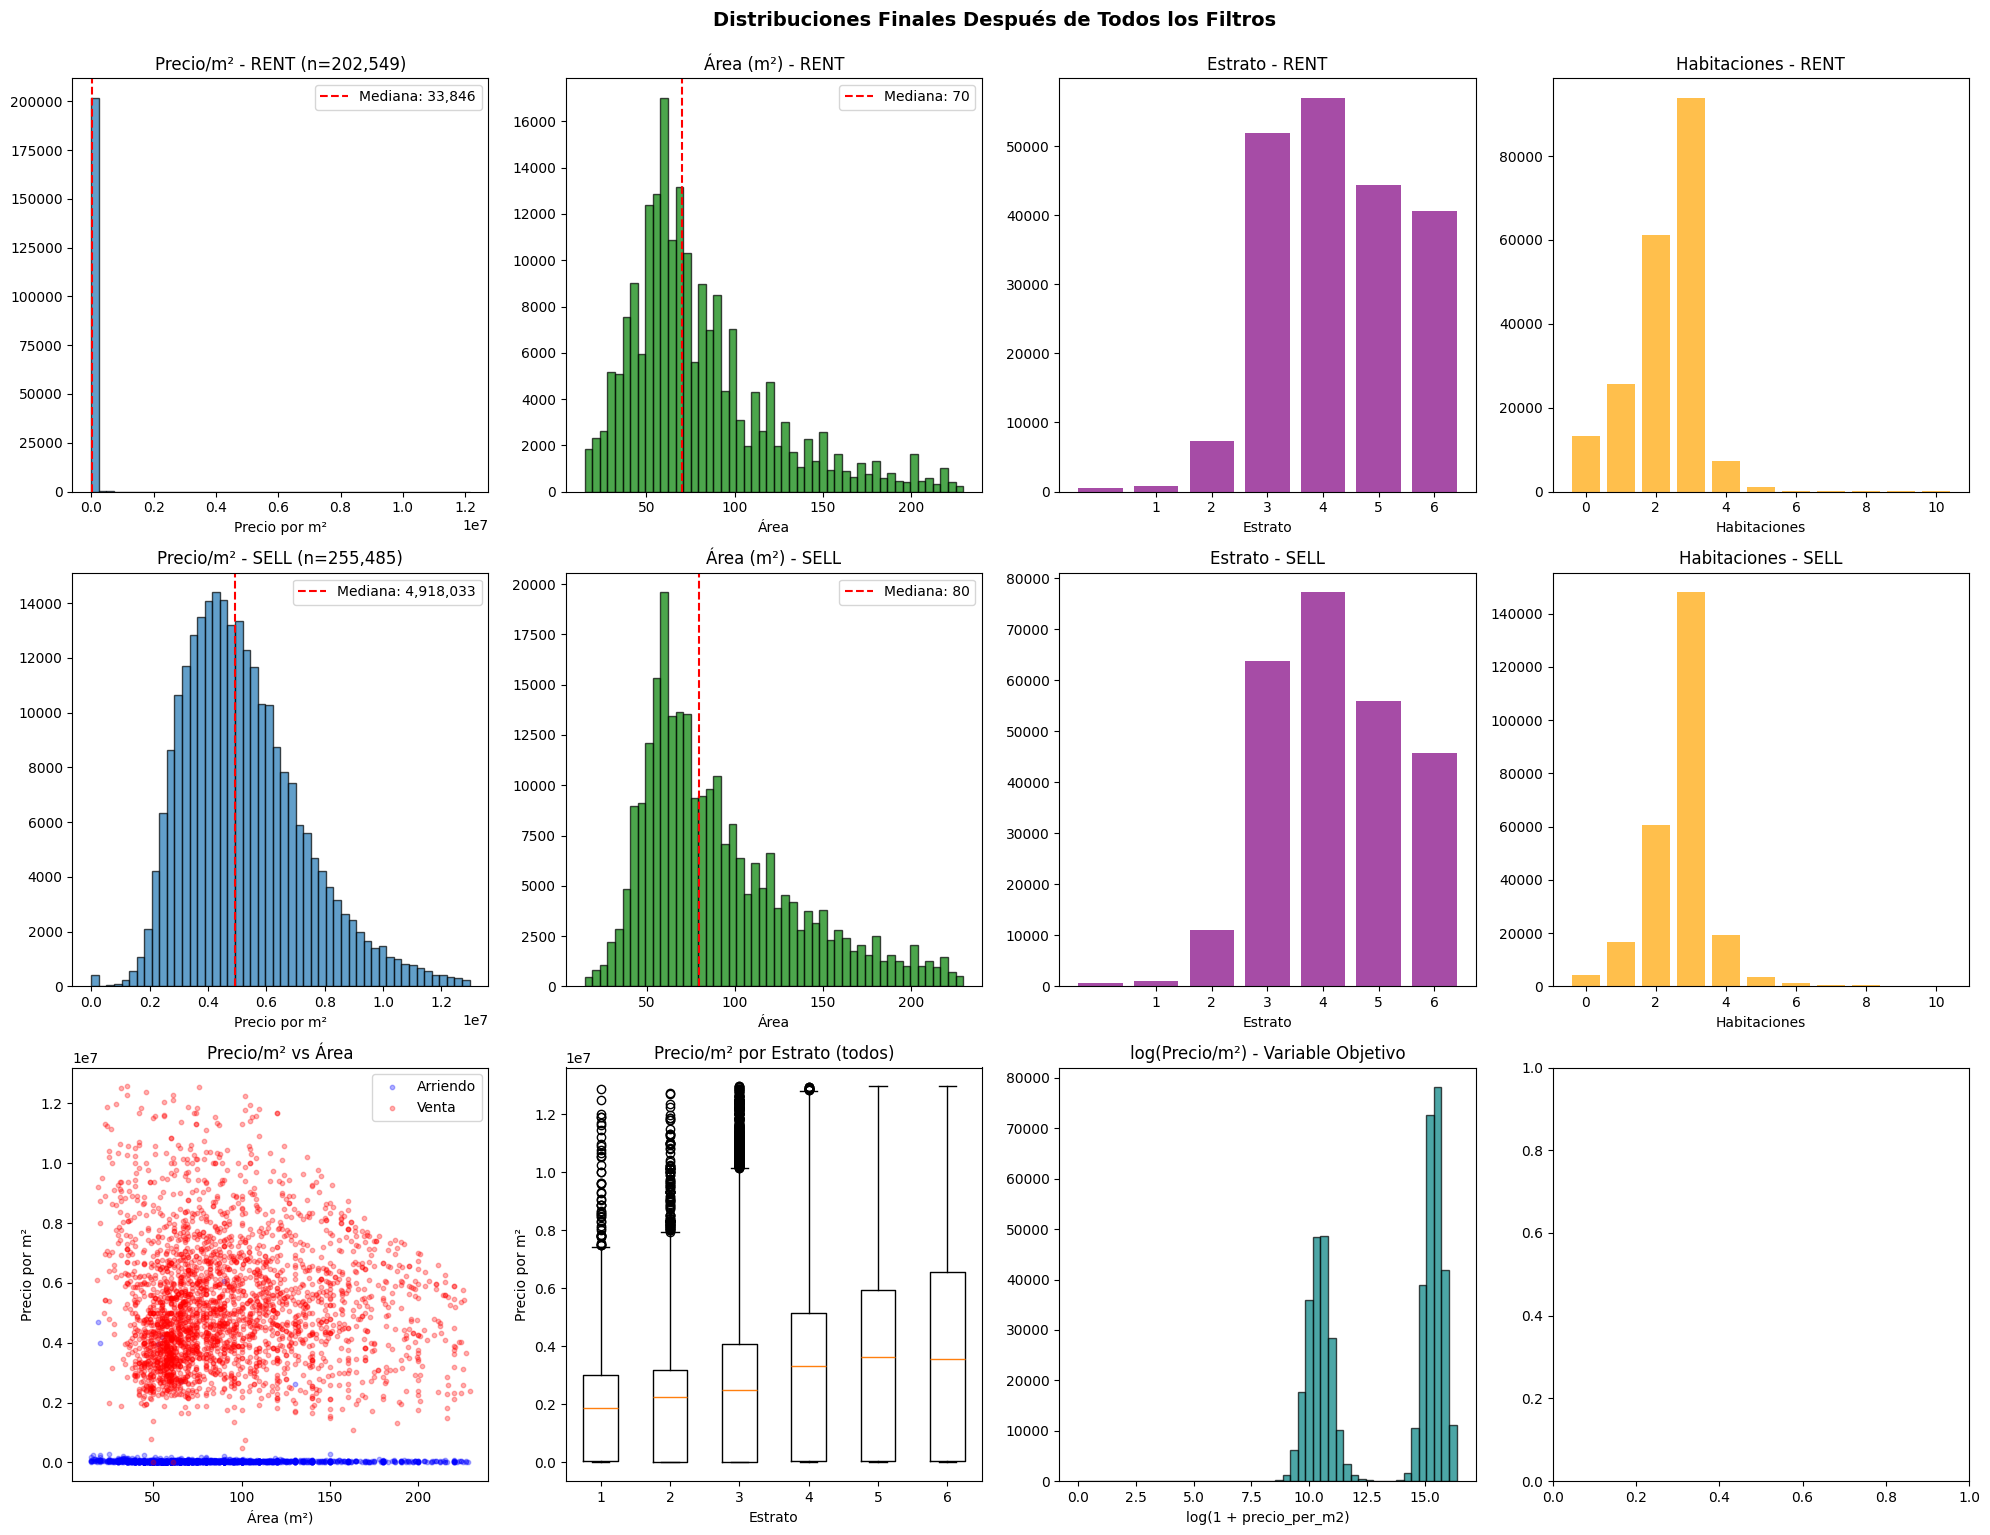


📊 MATRIZ DE CORRELACIÓN CON PRECIO/M²

📈 Correlación de features con precio/m²:
  garages             : +0.213 ████
  stratum             : +0.161 ███
  baths               : +0.155 ███
  area                : +0.097 █
  rooms               : +0.062 █
  area_per_room       : +0.056 █
  longitude           : +0.054 █
  latitude            : -0.027 
  antiquity           : -0.034 

📋 RESUMEN DE DATOS LISTOS PARA MODELADO
  Total registros: 458,034
  - RENT: 202,549
  - SELL: 255,485

  Columnas disponibles: 21
  Features numéricas: 10


In [10]:
# =============================================================================
# 📈 VISUALIZACIÓN FINAL DESPUÉS DE TODOS LOS FILTROS
# =============================================================================
print("=" * 80)
print("📈 VISUALIZACIÓN DE DATOS DESPUÉS DE APLICAR TODOS LOS FILTROS")
print("=" * 80)

# Usar df_filtered si existe, sino df
df_viz = df_filtered if 'df_filtered' in dir() else df.copy()
print(f"\n📊 Visualizando {len(df_viz):,} registros")

# Asegurar columnas numéricas
for col in ['price_per_m2', 'area', 'stratum', 'rooms', 'baths', 'garages', 'antiquity', 'latitude', 'longitude']:
    if col in df_viz.columns:
        df_viz[col] = pd.to_numeric(df_viz[col], errors='coerce')

# Eliminar filas con NaN en columnas críticas
df_viz = df_viz.dropna(subset=['price_per_m2', 'area'])
print(f"📊 Después de limpiar NaN: {len(df_viz):,} registros")

# Crear price_per_m2_log si no existe
if 'price_per_m2_log' not in df_viz.columns:
    df_viz['price_per_m2_log'] = np.log1p(df_viz['price_per_m2'])

# Crear area_per_room si no existe
if 'area_per_room' not in df_viz.columns:
    df_viz['area_per_room'] = df_viz['area'] / df_viz['rooms'].replace(0, 1)

fig, axes = plt.subplots(3, 4, figsize=(20, 15))

for idx, offer in enumerate(['rent', 'sell']):
    df_offer = df_viz[df_viz['offer'] == offer]
    row = idx
    
    if len(df_offer) > 0:
        # Precio por m²
        axes[row, 0].hist(df_offer['price_per_m2'].dropna(), bins=50, alpha=0.7, edgecolor='black')
        axes[row, 0].set_title(f'Precio/m² - {offer.upper()} (n={len(df_offer):,})')
        axes[row, 0].set_xlabel('Precio por m²')
        median_val = df_offer['price_per_m2'].median()
        if pd.notna(median_val):
            axes[row, 0].axvline(median_val, color='red', linestyle='--', label=f'Mediana: {median_val:,.0f}')
            axes[row, 0].legend()
        
        # Área
        axes[row, 1].hist(df_offer['area'].dropna(), bins=50, alpha=0.7, color='green', edgecolor='black')
        axes[row, 1].set_title(f'Área (m²) - {offer.upper()}')
        axes[row, 1].set_xlabel('Área')
        median_val = df_offer['area'].median()
        if pd.notna(median_val):
            axes[row, 1].axvline(median_val, color='red', linestyle='--', label=f'Mediana: {median_val:,.0f}')
            axes[row, 1].legend()
        
        # Estrato
        stratum_data = df_offer['stratum'].dropna()
        if len(stratum_data) > 0:
            stratum_counts = stratum_data.value_counts().sort_index()
            axes[row, 2].bar(stratum_counts.index.astype(int), stratum_counts.values, color='purple', alpha=0.7)
            axes[row, 2].set_title(f'Estrato - {offer.upper()}')
            axes[row, 2].set_xlabel('Estrato')
            axes[row, 2].set_xticks([1, 2, 3, 4, 5, 6])
        
        # Habitaciones
        rooms_data = df_offer['rooms'].dropna()
        if len(rooms_data) > 0:
            rooms_counts = rooms_data.value_counts().sort_index()
            axes[row, 3].bar(rooms_counts.index.astype(int), rooms_counts.values, color='orange', alpha=0.7)
            axes[row, 3].set_title(f'Habitaciones - {offer.upper()}')
            axes[row, 3].set_xlabel('Habitaciones')
    else:
        for col in range(4):
            axes[row, col].text(0.5, 0.5, 'Sin datos', ha='center', va='center', fontsize=12)
            axes[row, col].set_title(f'{offer.upper()} - Sin datos')

# Fila 3: Relaciones importantes
# Precio/m² vs Área (scatter con sample)
sample_size = min(5000, len(df_viz))
if sample_size > 0:
    df_sample = df_viz.sample(n=sample_size, random_state=42)
    
    rent_data = df_sample[df_sample['offer']=='rent']
    sell_data = df_sample[df_sample['offer']=='sell']
    
    if len(rent_data) > 0:
        axes[2, 0].scatter(rent_data['area'], rent_data['price_per_m2'], 
                           alpha=0.3, s=10, label='Arriendo', c='blue')
    if len(sell_data) > 0:
        axes[2, 0].scatter(sell_data['area'], sell_data['price_per_m2'], 
                           alpha=0.3, s=10, label='Venta', c='red')
    axes[2, 0].set_title('Precio/m² vs Área')
    axes[2, 0].set_xlabel('Área (m²)')
    axes[2, 0].set_ylabel('Precio por m²')
    axes[2, 0].legend()
    
    # Precio/m² vs Estrato - boxplot
    stratum_groups = []
    stratum_labels = []
    for s in range(1, 7):
        s_data = df_viz[df_viz['stratum']==s]['price_per_m2'].dropna().values
        if len(s_data) > 0:
            stratum_groups.append(s_data)
            stratum_labels.append(str(s))
    
    if len(stratum_groups) > 0:
        axes[2, 1].boxplot(stratum_groups, labels=stratum_labels)
        axes[2, 1].set_title('Precio/m² por Estrato (todos)')
        axes[2, 1].set_xlabel('Estrato')
        axes[2, 1].set_ylabel('Precio por m²')
    
    # Distribución logarítmica (variable objetivo)
    log_data = df_viz['price_per_m2_log'].dropna()
    if len(log_data) > 0:
        axes[2, 2].hist(log_data, bins=50, alpha=0.7, color='teal', edgecolor='black')
        axes[2, 2].set_title('log(Precio/m²) - Variable Objetivo')
        axes[2, 2].set_xlabel('log(1 + precio_per_m2)')
    
    # Location field removed - show property types instead
    if 'property_type' in df_viz.columns:
        type_counts = df_viz['property_type'].value_counts().head(10)
        type_names = [PROPERTY_TYPE_NAMES.get(int(t), f'Tipo {t}') for t in type_counts.index]
        axes[2, 3].barh(type_names[::-1], type_counts.values[::-1], color='coral')
        axes[2, 3].set_title('Tipos de Propiedad')
        axes[2, 3].set_xlabel('Cantidad de registros')

plt.tight_layout()
plt.suptitle('Distribuciones Finales Después de Todos los Filtros', y=1.02, fontsize=14, fontweight='bold')
plt.show()

# Correlaciones finales
print("\n" + "="*60)
print("📊 MATRIZ DE CORRELACIÓN CON PRECIO/M²")
print("="*60)

numeric_features = ['price_per_m2', 'area', 'rooms', 'baths', 'garages', 'stratum', 
                   'latitude', 'longitude', 'antiquity', 'area_per_room']
valid_cols = [c for c in numeric_features if c in df_viz.columns and pd.api.types.is_numeric_dtype(df_viz[c])]

if len(valid_cols) > 1 and 'price_per_m2' in valid_cols:
    # Correlación con price_per_m2
    corr_matrix = df_viz[valid_cols].corr()
    if 'price_per_m2' in corr_matrix.columns:
        correlations = corr_matrix['price_per_m2'].drop('price_per_m2', errors='ignore').sort_values(ascending=False)
        correlations = correlations.dropna()  # Eliminar NaN
        
        print("\n📈 Correlación de features con precio/m²:")
        for feat, corr in correlations.items():
            if pd.notna(corr):
                bar_len = int(abs(corr) * 20)
                bar = "█" * bar_len
                sign = "+" if corr > 0 else "-"
                print(f"  {feat:20s}: {corr:+.3f} {bar}")
else:
    print("\n⚠️ No hay suficientes columnas numéricas para calcular correlaciones")

# Resumen final
print("\n" + "="*60)
print("📋 RESUMEN DE DATOS LISTOS PARA MODELADO")
print("="*60)
print(f"  Total registros: {len(df_viz):,}")
for offer in ['rent', 'sell']:
    count = len(df_viz[df_viz['offer'] == offer])
    print(f"  - {offer.upper()}: {count:,}")
print(f"\n  Columnas disponibles: {len(df_viz.columns)}")
print(f"  Features numéricas: {len(valid_cols)}")

## Preprocesamiento y Feature Engineering

In [11]:
# =============================================================================
# PREPROCESAMIENTO Y FEATURE ENGINEERING
# =============================================================================

def extract_property_type(title):
    """
    Extrae el tipo de propiedad del título.
    Retorna: 1=Apartamento, 2=Casa, 3=Oficina, 4=Local, 5=Bodega, 6=Lote, 0=Otro/Desconocido
    """
    if pd.isna(title):
        return 0
    title_lower = str(title).lower()
    
    if 'apartamento' in title_lower or 'apto' in title_lower:
        return 1  # Apartamento
    elif 'casa' in title_lower:
        return 2  # Casa
    elif 'oficina' in title_lower:
        return 3  # Oficina
    elif 'local' in title_lower:
        return 4  # Local comercial
    elif 'bodega' in title_lower:
        return 5  # Bodega
    elif 'lote' in title_lower or 'terreno' in title_lower:
        return 6  # Lote/Terreno
    elif 'estudio' in title_lower:
        return 7  # Estudio
    elif 'penthouse' in title_lower or 'pent house' in title_lower:
        return 8  # Penthouse
    elif 'duplex' in title_lower or 'dúplex' in title_lower:
        return 9  # Duplex
    else:
        return 0  # Otro/Desconocido

# Diccionario para mostrar nombres
PROPERTY_TYPE_NAMES = {
    0: 'Otro/Desconocido',
    1: 'Apartamento',
    2: 'Casa',
    3: 'Oficina',
    4: 'Local',
    5: 'Bodega',
    6: 'Lote/Terreno',
    7: 'Estudio',
    8: 'Penthouse',
    9: 'Duplex'
}

def preprocess(df_in):
    """Preprocesamiento básico de datos"""
    df_in = df_in.copy()
    
    # Normalizar offer
    df_in['offer'] = df_in['offer'].astype(str).str.lower().str.strip()
    df_in['is_new'] = df_in['is_new'].astype(str).fillna('unknown').str.lower()
    
    # ========== NUEVO: Extraer tipo de propiedad del título ==========
    if 'title' in df_in.columns:
        df_in['property_type'] = df_in['title'].apply(extract_property_type)
        print(f"📊 Tipos de propiedad extraídos del título:")
        type_counts = df_in['property_type'].value_counts().sort_index()
        for type_id, count in type_counts.items():
            print(f"   {PROPERTY_TYPE_NAMES.get(type_id, 'Unknown')}: {count:,}")
    else:
        df_in['property_type'] = 0
    
    # Manejar antigüedad
    if 'antiquity' in df_in.columns:
        df_in['antiquity'] = pd.to_numeric(df_in['antiquity'], errors='coerce').fillna(-1)
    else:
        df_in['antiquity'] = -1
    
    # Columnas numéricas - Convertir a numérico, manejar "Sin especificar" y otros textos
    num_cols = ['rooms', 'baths', 'garages', 'stratum', 'latitude', 'longitude']
    for c in num_cols:
        if c in df_in.columns:
            df_in[c] = pd.to_numeric(df_in[c], errors='coerce').fillna(-1)
        else:
            df_in[c] = -1
    
    # Location field removed from model
    
    return df_in

def add_features(df_in):
    """Añadir features derivadas"""
    df_in = df_in.copy()
    
    # Área por habitación - manejar división por cero usando np.where
    rooms_safe = df_in['rooms'].replace({-1: np.nan, 0: np.nan})
    df_in['area_per_room'] = df_in['area'] / rooms_safe
    # Usar np.where para reemplazar NaN e infinitos con el área
    df_in['area_per_room'] = np.where(
        (df_in['area_per_room'].isna()) | (np.isinf(df_in['area_per_room'])),
        df_in['area'],
        df_in['area_per_room']
    )
    
    # Coordenadas redondeadas
    df_in['lat_round'] = df_in['latitude'].round(3)
    df_in['lon_round'] = df_in['longitude'].round(3)
    
    # Bucket de antigüedad basado en las categorías de la BD
    # antiquity ya viene como: 0=Sin especificar, 1=<1año, 2=1-8años, 3=9-15años, 4=16-30años, 5=>30años
    antiquity_map = {
        0: 'sin_especificar',
        1: 'menos_1_ano',
        2: '1_a_8_anos',
        3: '9_a_15_anos',
        4: '16_a_30_anos',
        5: 'mas_30_anos'
    }
    df_in['age_bucket'] = df_in['antiquity'].map(antiquity_map).fillna('sin_especificar')
    
    # Flag de garaje
    df_in['has_garage'] = (df_in['garages'] > 0).astype(int)
    
    # Transformación logarítmica SOLO para price_per_m2 (variable objetivo)
    df_in['price_per_m2_log'] = np.log1p(df_in['price_per_m2'])
    
    return df_in

# Usar df_filtered si existe, sino df
df_to_process = df_filtered.copy() if 'df_filtered' in dir() and len(df_filtered) > 0 else df.copy()

# Aplicar preprocesamiento
df = preprocess(df_to_process)
df = add_features(df)

print(f"✅ Preprocesamiento completado: {df.shape}")
print(f"\nDistribución por tipo de oferta:")
print(df['offer'].value_counts())

📊 Tipos de propiedad extraídos del título:
   Otro/Desconocido: 3,102
   Apartamento: 379,309
   Casa: 30,040
   Oficina: 16,387
   Local: 14,566
   Bodega: 992
   Lote/Terreno: 477
   Estudio: 13,161
✅ Preprocesamiento completado: (458034, 26)

Distribución por tipo de oferta:
offer
sell    255485
rent    202549
Name: count, dtype: int64


## Preparación de Datos para Entrenamiento

In [12]:
# =============================================================================
# PREPARACIÓN DE DATOS PARA ENTRENAMIENTO
# =============================================================================
def prepare_Xy(df_local, features=FEATURES):
    """Prepara X e y para el entrenamiento"""
    X = df_local[features].copy()
    
    for c in X.columns:
        if c in CAT_FEATURES:
            if pd.api.types.is_numeric_dtype(X[c]):
                X[c] = X[c].fillna(-1).astype(str)
            else:
                X[c] = X[c].astype(object).fillna('missing').astype(str)
            X[c] = X[c].astype('category')
        else:
            X[c] = pd.to_numeric(X[c], errors='coerce').fillna(-1)
            # Reemplazar infinitos con -1
            X[c] = X[c].replace([np.inf, -np.inf], -1)
    
    y = df_local['price_per_m2_log'].values
    return X, y

def prepare_for_sklearn(X_train, X_val):
    """Prepara datos con one-hot encoding para modelos sklearn"""
    cat_cols = [c for c in CAT_FEATURES if c in X_train.columns]
    
    X_train_ohe = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
    X_val_ohe = pd.get_dummies(X_val, columns=cat_cols, drop_first=True)
    
    # Alinear columnas
    train_cols = X_train_ohe.columns
    for c in set(train_cols) - set(X_val_ohe.columns):
        X_val_ohe[c] = 0
    X_val_ohe = X_val_ohe[train_cols]
    
    # Asegurar que no hay valores infinitos o NaN
    X_train_ohe = X_train_ohe.replace([np.inf, -np.inf], 0).fillna(0)
    X_val_ohe = X_val_ohe.replace([np.inf, -np.inf], 0).fillna(0)
    
    return X_train_ohe, X_val_ohe

print("✅ Funciones de preparación definidas")

✅ Funciones de preparación definidas


## Entrenamiento de Modelos (CatBoost, LightGBM, RandomForest, Linear Regression)

In [13]:
# =============================================================================
# FUNCIÓN DE ENTRENAMIENTO - LightGBM para Renta, CatBoost para Venta
# =============================================================================
def train_model(df_offer, offer_name="rent"):
    """Entrena LightGBM para renta o CatBoost para venta"""
    X, y = prepare_Xy(df_offer)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    print(f"\n{'='*60}")
    print(f"ENTRENAMIENTO PARA: {offer_name.upper()}")
    print(f"{'='*60}")
    print(f"Train: {X_train.shape}, Validation: {X_val.shape}")
    
    trained_models = {}
    results = []
    
    if offer_name == 'rent':
        # -------------------------------------------------------------------------
        # LIGHTGBM para RENTA
        # -------------------------------------------------------------------------
        print(f"\n🟢 Entrenando LightGBM (modelo seleccionado para RENTA)...")
        try:
            cat_features = [f for f in CAT_FEATURES if f in X_train.columns]
            train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features, free_raw_data=False)
            val_data = lgb.Dataset(X_val, label=y_val, reference=train_data, categorical_feature=cat_features, free_raw_data=False)
            
            params = {
                'objective': 'regression', 'metric': 'rmse',
                'learning_rate': 0.05, 'num_leaves': 31, 'verbose': -1,
                'seed': 42, 'bagging_seed': 42, 'feature_fraction_seed': 42
            }
            
            model_lgb = lgb.train(
                params, train_data, valid_sets=[val_data], 
                num_boost_round=500, 
                callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
            )
            
            y_pred = model_lgb.predict(X_val)
            trained_models['lightgbm'] = model_lgb
            results.append({
                'model': 'LightGBM',
                'rmse': rmse(y_val, y_pred),
                'mape': mape(np.expm1(y_val), np.expm1(y_pred)),
                'r2': r2_score(y_val, y_pred)
            })
            print(f"   ✅ LightGBM: RMSE={results[-1]['rmse']:.4f}, R²={results[-1]['r2']:.4f}")
        except Exception as e:
            print(f"   ❌ LightGBM falló: {e}")
    
    else:  # sell
        # -------------------------------------------------------------------------
        # CATBOOST para VENTA
        # -------------------------------------------------------------------------
        print(f"\n🔵 Entrenando CatBoost (modelo seleccionado para VENTA)...")
        try:
            cat_idx = [i for i, c in enumerate(X.columns) if c in CAT_FEATURES]
            train_pool = Pool(X_train, y_train, cat_features=cat_idx)
            val_pool = Pool(X_val, y_val, cat_features=cat_idx)
            
            model_cb = CatBoostRegressor(
                loss_function='RMSE', iterations=500, learning_rate=0.05, 
                depth=7, random_seed=42, verbose=0
            )
            model_cb.fit(train_pool, eval_set=val_pool, use_best_model=True)
            
            y_pred = model_cb.predict(X_val)
            trained_models['catboost'] = model_cb
            results.append({
                'model': 'CatBoost', 
                'rmse': rmse(y_val, y_pred),
                'mape': mape(np.expm1(y_val), np.expm1(y_pred)),
                'r2': r2_score(y_val, y_pred)
            })
            print(f"   ✅ CatBoost: RMSE={results[-1]['rmse']:.4f}, R²={results[-1]['r2']:.4f}")
        except Exception as e:
            print(f"   ❌ CatBoost falló: {e}")
    
    return trained_models, pd.DataFrame(results), X.columns.tolist()

print("✅ Función de entrenamiento definida (LightGBM para renta, CatBoost para venta)")

✅ Función de entrenamiento definida (LightGBM para renta, CatBoost para venta)


## Ejecución del Entrenamiento

In [14]:
# =============================================================================
# ENTRENAR MODELOS PARA ARRIENDO Y VENTA
# =============================================================================
all_models = {}
all_results = {}
feature_cols = None

for offer in ['rent', 'sell']:
    df_offer = df[df['offer'] == offer].copy()
    
    if df_offer.shape[0] < 50:
        print(f"⚠️ Omitiendo '{offer}' — solo hay {df_offer.shape[0]} ejemplos")
        continue
    
    models, results_df, feature_cols = train_model(df_offer, offer_name=offer)
    all_models[offer] = models
    all_results[offer] = results_df

print("\n" + "="*60)
print("RESUMEN DE ENTRENAMIENTO COMPLETADO")
print("="*60)
print("  - RENT: LightGBM")
print("  - SELL: CatBoost")


ENTRENAMIENTO PARA: RENT
Train: (162039, 14), Validation: (40510, 14)

🟢 Entrenando LightGBM (modelo seleccionado para RENTA)...
   ✅ LightGBM: RMSE=0.3383, R²=0.6379

ENTRENAMIENTO PARA: SELL
Train: (204388, 14), Validation: (51097, 14)

🔵 Entrenando CatBoost (modelo seleccionado para VENTA)...
   ✅ CatBoost: RMSE=0.3136, R²=0.5361

RESUMEN DE ENTRENAMIENTO COMPLETADO
  - RENT: LightGBM
  - SELL: CatBoost


## Guardado de Modelos y Función de Predicción

In [ ]:
# =============================================================================
# GUARDADO DE MODELOS
# =============================================================================
OUT_DIR = Path('models')
OUT_DIR.mkdir(exist_ok=True)

metadata = {}

for offer, models in all_models.items():
    metadata[offer] = {}
    
    for model_name, model in models.items():
        if model_name == 'catboost':
            model_path = OUT_DIR / f"model_{offer}_{model_name}2.cbm"
            model.save_model(str(model_path))
        elif model_name == 'lightgbm':
            model_path = OUT_DIR / f"model_{offer}_{model_name}2.txt"
            model.save_model(str(model_path))
        
        metadata[offer][model_name] = {
            "model_path": str(model_path),
            "features": feature_cols,
            "trained_at": datetime.utcnow().isoformat()
        }

with open(OUT_DIR / "metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)

print(f"✅ Modelos guardados en: {OUT_DIR}")
print(f"\nModelos guardados:")
print(f"  - rent/lightgbm: {metadata['rent']['lightgbm']['model_path']}")
print(f"  - sell/catboost: {metadata['sell']['catboost']['model_path']}")

✅ Modelos guardados en: models

Modelos guardados:
  - rent/lightgbm: models\model_rent_lightgbm.txt
  - sell/catboost: models\model_sell_catboost.cbm


In [16]:
# =============================================================================
# FUNCIÓN DE PREDICCIÓN
# =============================================================================
def load_model(offer):
    """Carga el modelo correspondiente: LightGBM para rent, CatBoost para sell"""
    meta = json.load(open(Path('models') / 'metadata.json'))
    
    # Seleccionar modelo según tipo de oferta
    model_type = 'lightgbm' if offer == 'rent' else 'catboost'
    
    if offer not in meta or model_type not in meta[offer]:
        raise ValueError(f"No hay modelo {model_type} para {offer}")
    
    info = meta[offer][model_type]
    model_path = info['model_path']
    features = info['features']
    
    if model_type == 'catboost':
        m = CatBoostRegressor()
        m.load_model(model_path)
    else:  # lightgbm
        m = lgb.Booster(model_file=model_path)
    
    return m, features, model_type

def predict_price_per_m2(offer, data_dict):
    """Predice el precio por m² usando LightGBM (rent) o CatBoost (sell)"""
    m, features, model_type = load_model(offer)
    X = pd.DataFrame([data_dict])[features].copy()
    
    for c in X.columns:
        if c in CAT_FEATURES:
            if pd.api.types.is_numeric_dtype(X[c]):
                X[c] = X[c].fillna(-1).astype(str)
            else:
                X[c] = X[c].fillna('missing').astype(str)
            X[c] = X[c].astype('category')
        else:
            X[c] = pd.to_numeric(X[c], errors='coerce').fillna(-1)
    
    pred = m.predict(X)
    return float(np.expm1(pred)[0])

print("✅ Funciones de predicción definidas")
print("   - rent: usa LightGBM")
print("   - sell: usa CatBoost")

✅ Funciones de predicción definidas
   - rent: usa LightGBM
   - sell: usa CatBoost


## Ejemplo de Uso

In [17]:
# property_type: 1=Apartamento, 2=Casa, 3=Oficina, 4=Local, 5=Bodega, 6=Lote, 7=Estudio, 8=Penthouse, 9=Duplex, 0=Otro
example = {
    "area": 80,
    "rooms": 3,
    "baths": 2,
    "garages": 1,
    "stratum": 4,
    "latitude": 4.6804879,
    "longitude": -74.0472935,
    "antiquity": 5,
    "is_new": "no",

    "area_per_room": 80/3,
    "age_bucket": "1-8",
    "has_garage": 1,
    "city_id": "1",
    "property_type": 1  # 1 = Apartamento
}

print("="*60)
print("EJEMPLO DE PREDICCIÓN")
print("="*60)
print(f"\nDatos de entrada:")
for k, v in example.items():
    print(f"  {k}: {v}")
print(f"  (property_type 1 = Apartamento)")

# Predicción de ARRIENDO (LightGBM)
print(f"\n📍 ARRIENDO (LightGBM):")
try:
    pred_rent = predict_price_per_m2('rent', example)
    print(f"  Precio por m²: ${pred_rent:,.0f}")
    print(f"  Precio total (80m²): ${pred_rent * 80:,.0f}")
except Exception as e:
    print(f"  Error: {e}")

# Predicción de VENTA (CatBoost)
print(f"\n📍 VENTA (CatBoost):")
try:
    pred_sell = predict_price_per_m2('sell', example)
    print(f"  Precio por m²: ${pred_sell:,.0f}")
    print(f"  Precio total (80m²): ${pred_sell * 80:,.0f}")
except Exception as e:
    print(f"  Error: {e}")

# Comparar Apartamento vs Casa
print(f"\n" + "="*60)
print("COMPARACIÓN APARTAMENTO vs CASA")
print("="*60)

for offer_type, model_name in [('rent', 'LightGBM'), ('sell', 'CatBoost')]:
    print(f"\n📍 {offer_type.upper()} ({model_name}):")
    
    # Apartamento
    ex_apto = example.copy()
    ex_apto['property_type'] = 1
    pred_apto = predict_price_per_m2(offer_type, ex_apto)
    
    # Casa
    ex_casa = example.copy()
    ex_casa['property_type'] = 2
    pred_casa = predict_price_per_m2(offer_type, ex_casa)
    
    diff = pred_casa - pred_apto
    diff_pct = (diff / pred_apto) * 100
    sign = "+" if diff > 0 else ""
    
    print(f"  Apartamento: ${pred_apto:,.0f}/m²")
    print(f"  Casa:        ${pred_casa:,.0f}/m²")
    print(f"  Diferencia:  {sign}{diff_pct:.1f}%")

EJEMPLO DE PREDICCIÓN

Datos de entrada:
  area: 80
  rooms: 3
  baths: 2
  garages: 1
  stratum: 4
  latitude: 4.6804879
  longitude: -74.0472935
  antiquity: 5
  is_new: no
  area_per_room: 26.666666666666668
  age_bucket: 1-8
  has_garage: 1
  city_id: 1
  property_type: 1
  (property_type 1 = Apartamento)

📍 ARRIENDO (LightGBM):
  Precio por m²: $30,219
  Precio total (80m²): $2,417,527

📍 VENTA (CatBoost):
  Precio por m²: $5,419,313
  Precio total (80m²): $433,545,043

COMPARACIÓN APARTAMENTO vs CASA

📍 RENT (LightGBM):
  Apartamento: $30,219/m²
  Casa:        $31,022/m²
  Diferencia:  +2.7%

📍 SELL (CatBoost):
  Apartamento: $5,419,313/m²
  Casa:        $5,592,796/m²
  Diferencia:  +3.2%


In [21]:
(30219*80)/0.0050

483504000.0

In [20]:
 5419313*80

433545040